1 REGRESSION LINEAIRE

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('WineQT.csv')

VISUALISATION DES DONNEES

Nous commençons par une étape de visualisation des données. Cette étape nous permet de voir la distribution de nos données.

In [6]:
def plot_hists(df):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
    for n in range(12):
        i = n % 3
        j = n % 4
        ax[i, j].hist(df.iloc[:, n], bins='auto')
        ax[i, j].set_xlabel(df.columns[n])

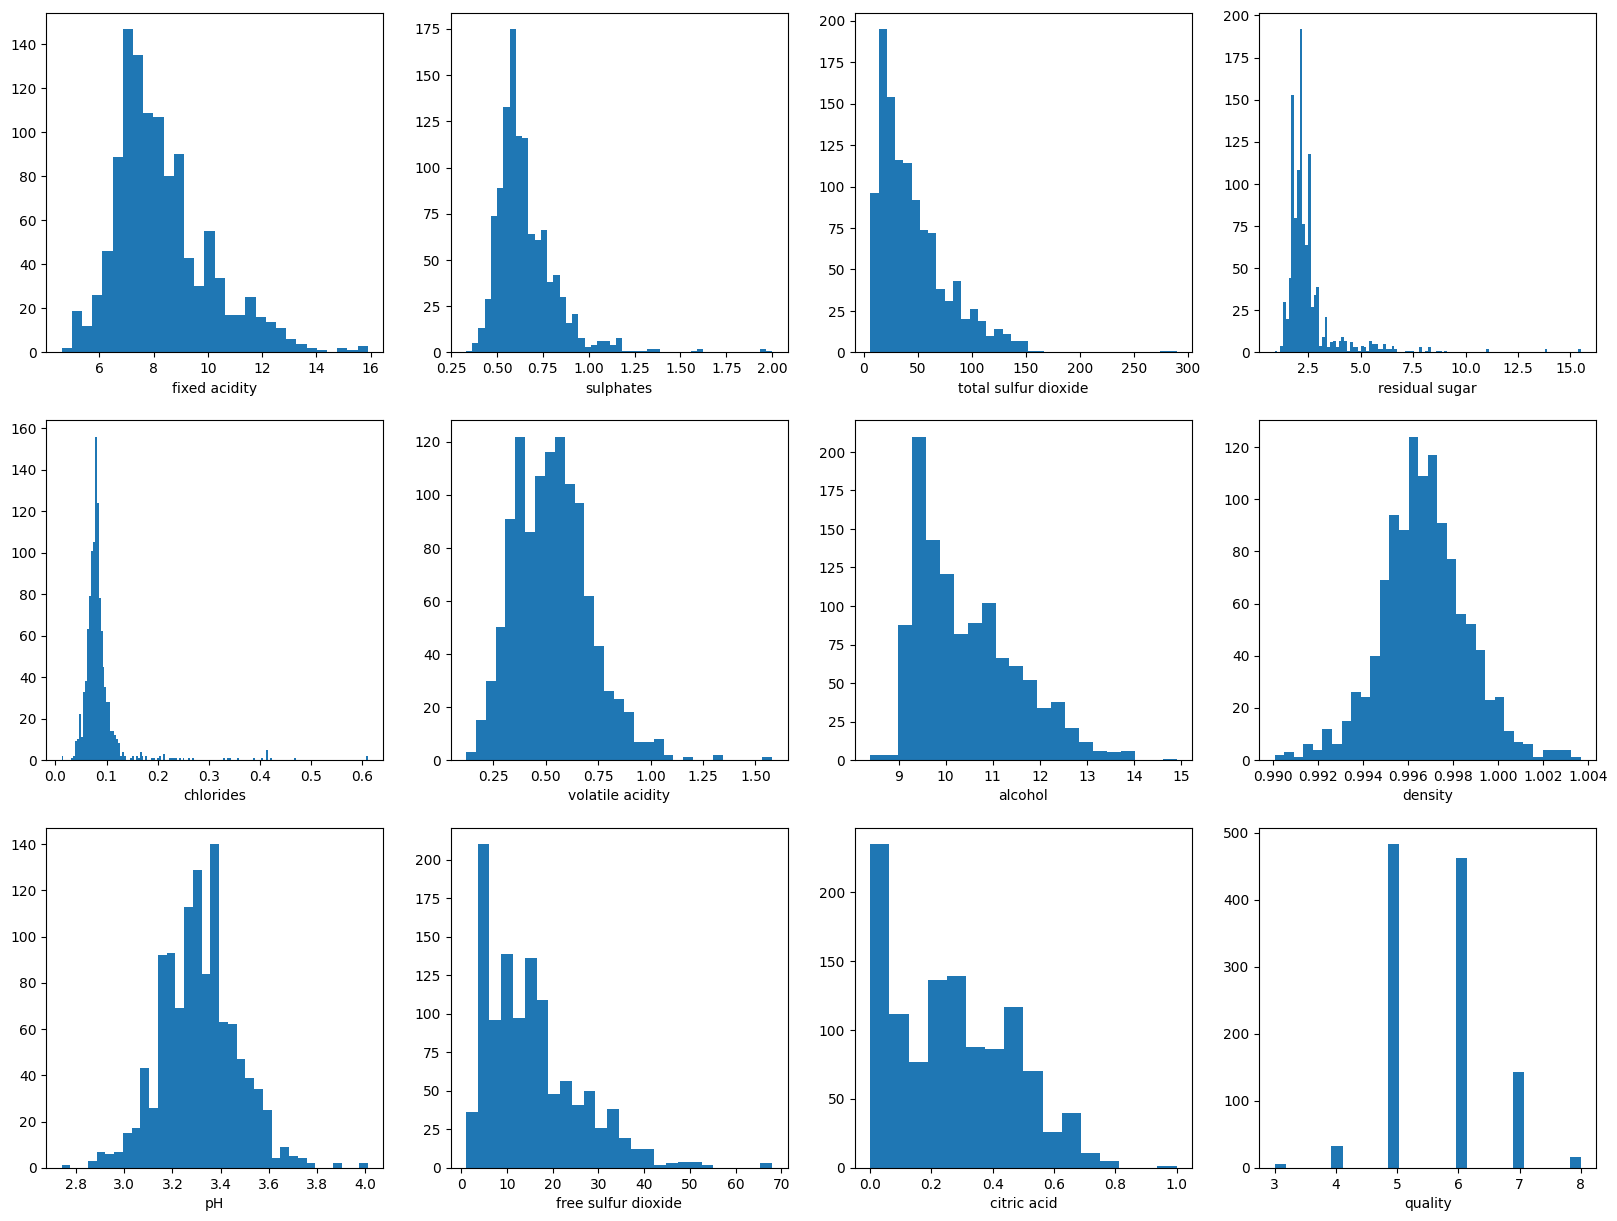

In [4]:
plot_hists(df)

Grâce à cette visualisation, nous modifions les colonnes qui ne semblent pas avoir une distribution normale.
On normalise avec un paramètre trouvé à la main pour chaque caractéristique et on standardise.

/home/henri/.local/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


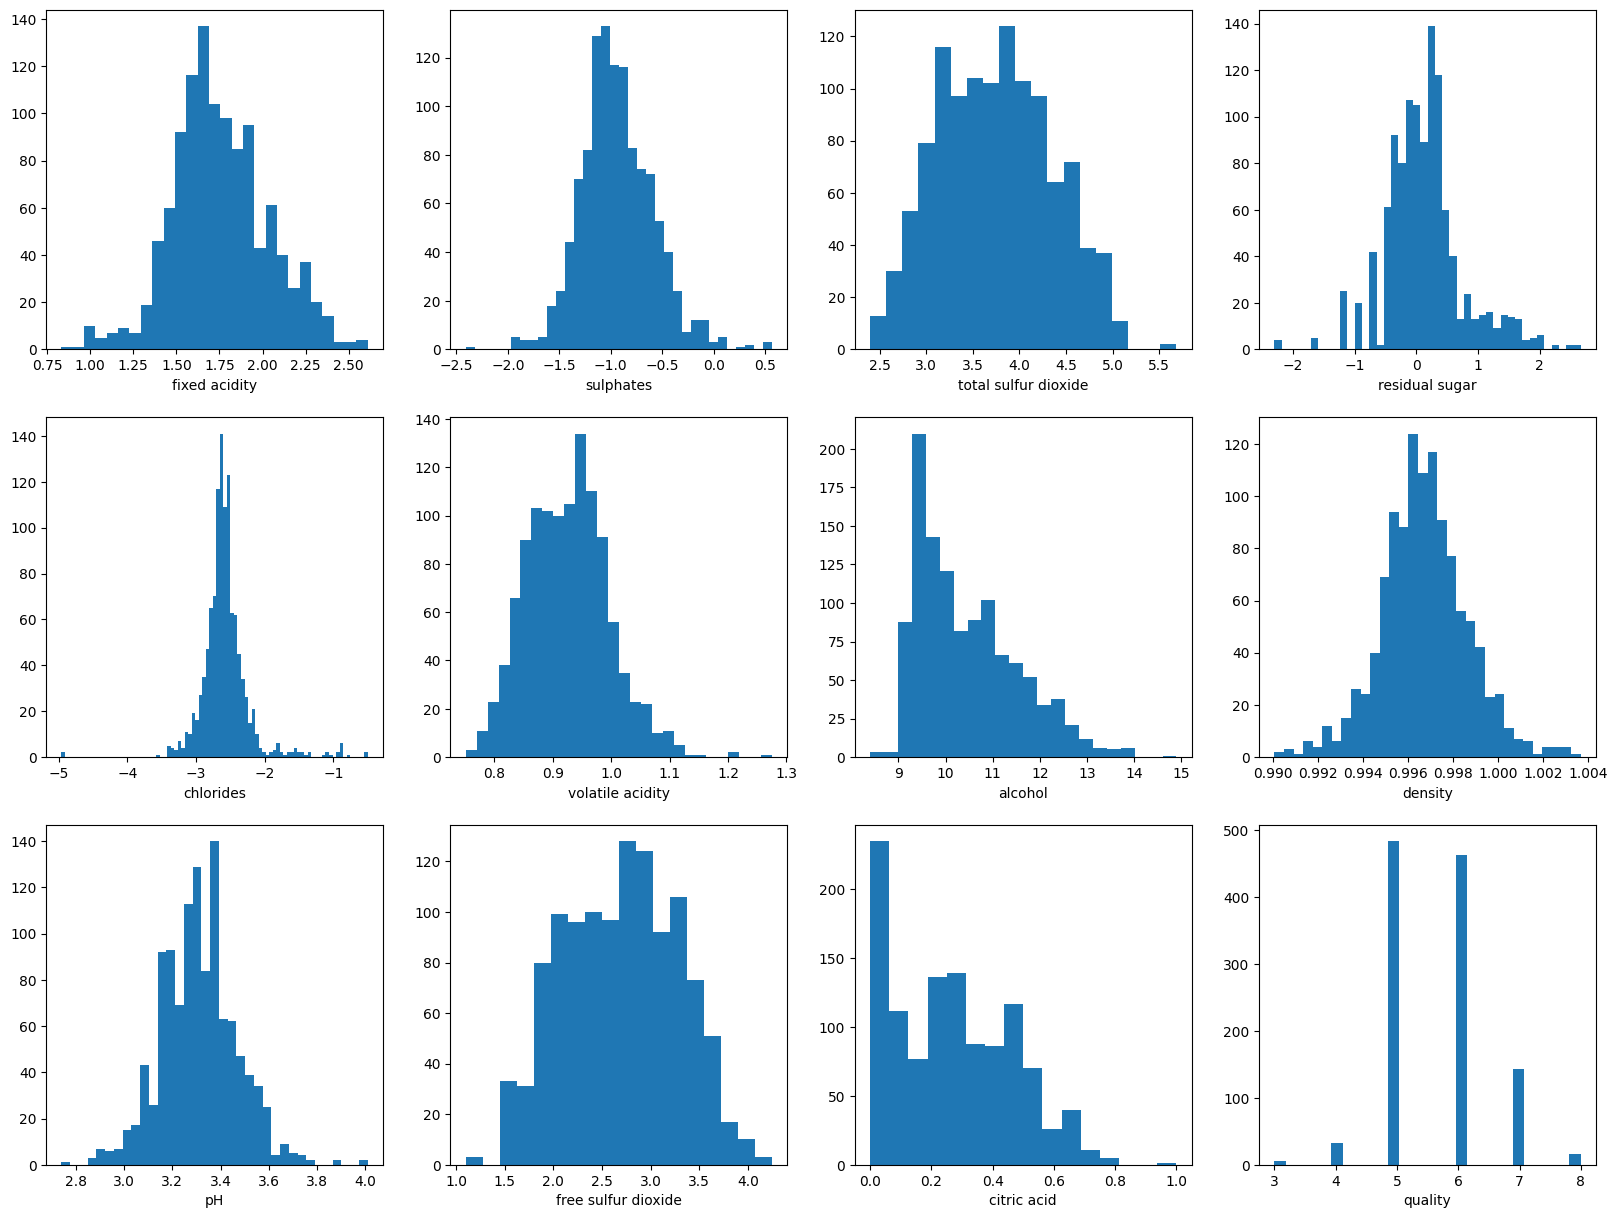

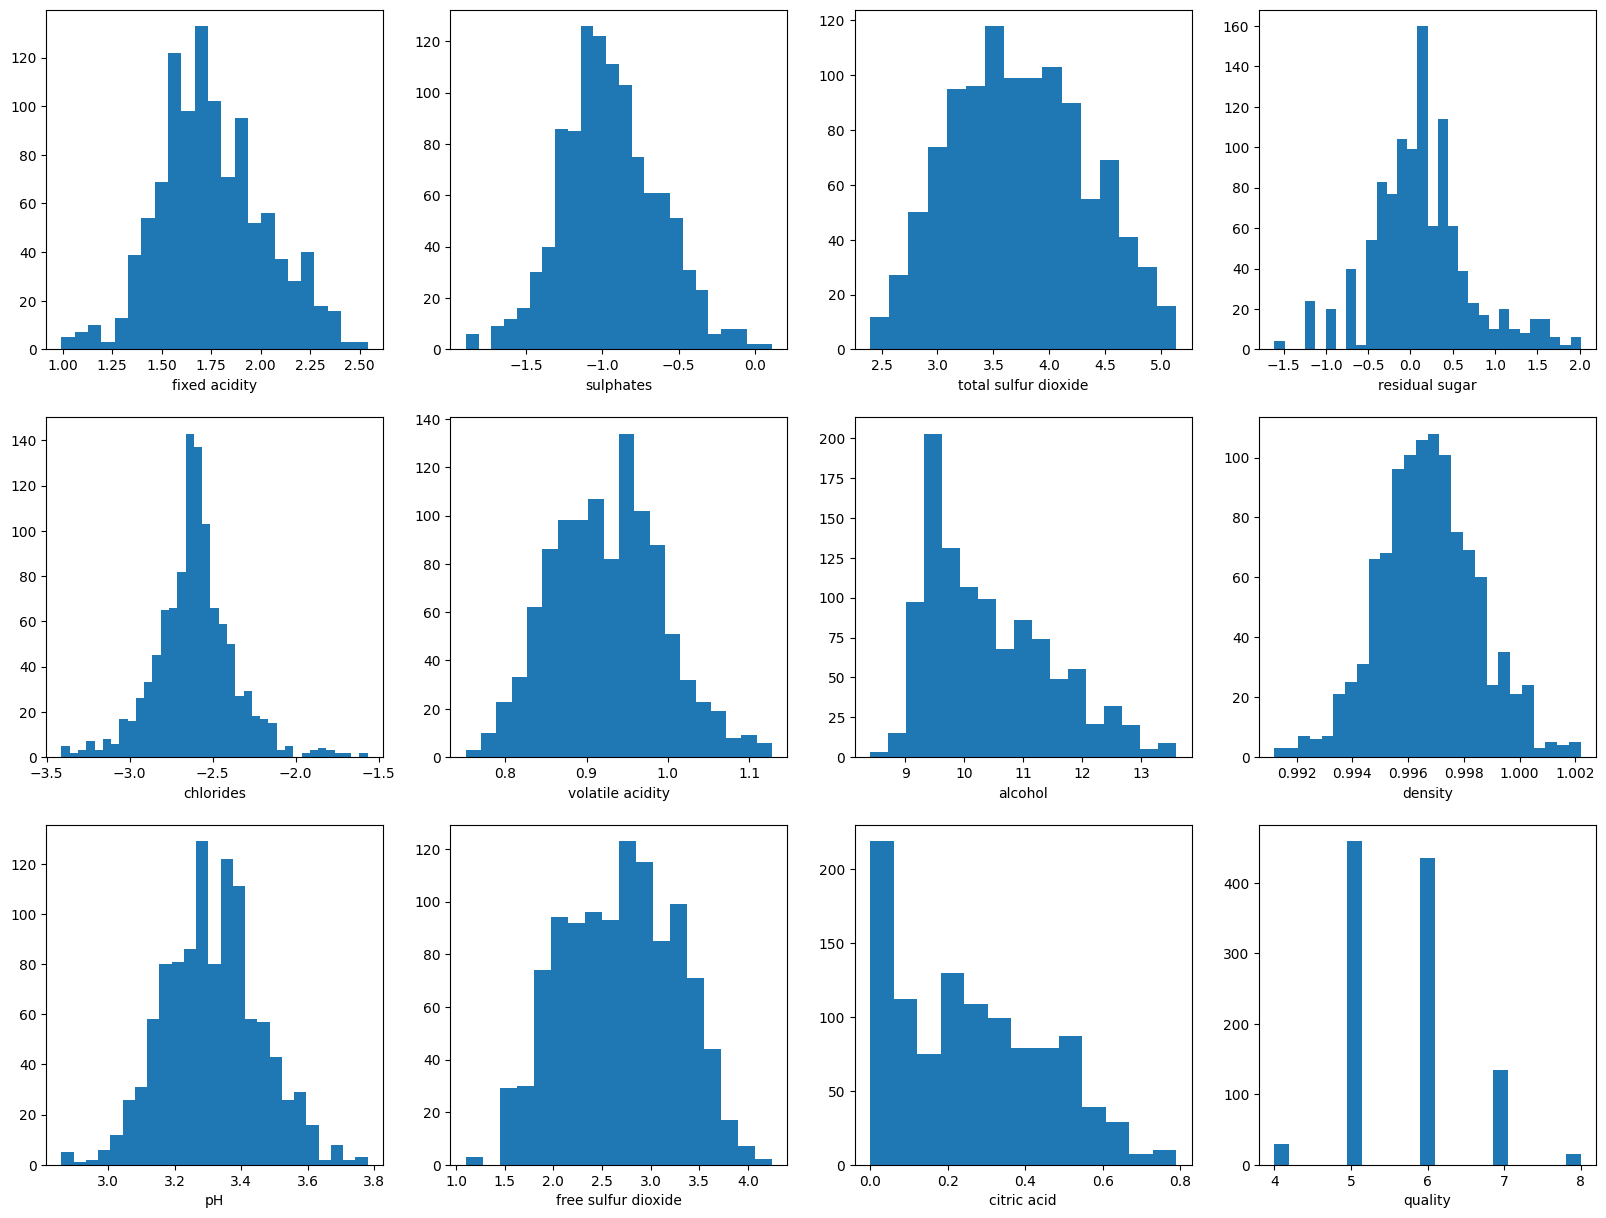

In [7]:
#mettre entre 0 et 1
def normalize(df, property, parameter):
    df[property] = np.log(df[property] + parameter)

normalize(df, "fixed acidity", -2.3)
normalize(df, "sulphates", -0.24)
normalize(df, "total sulfur dioxide", 5)
normalize(df, "residual sugar", -1.1)
normalize(df, "chlorides", -0.005)
normalize(df, "volatile acidity", 2)
normalize(df, "free sulfur dioxide", 2)
plot_hists(df)

#On enlève les observations anormales
standardized = (df - df.mean()) / df.std()
standardized = standardized[(np.abs(standardized) < 3).all(axis=1)]
rows = np.setdiff1d(list(df.index), list(standardized.index))
df.drop(index=rows, inplace=True)
plot_hists(df)

Souhaitant prédire la qualité, nous allons afficher les graph des différentes caractéristiques en fonction de la qualité, ainsi qu'une matrice de corrélation linéaire.

<Axes: >

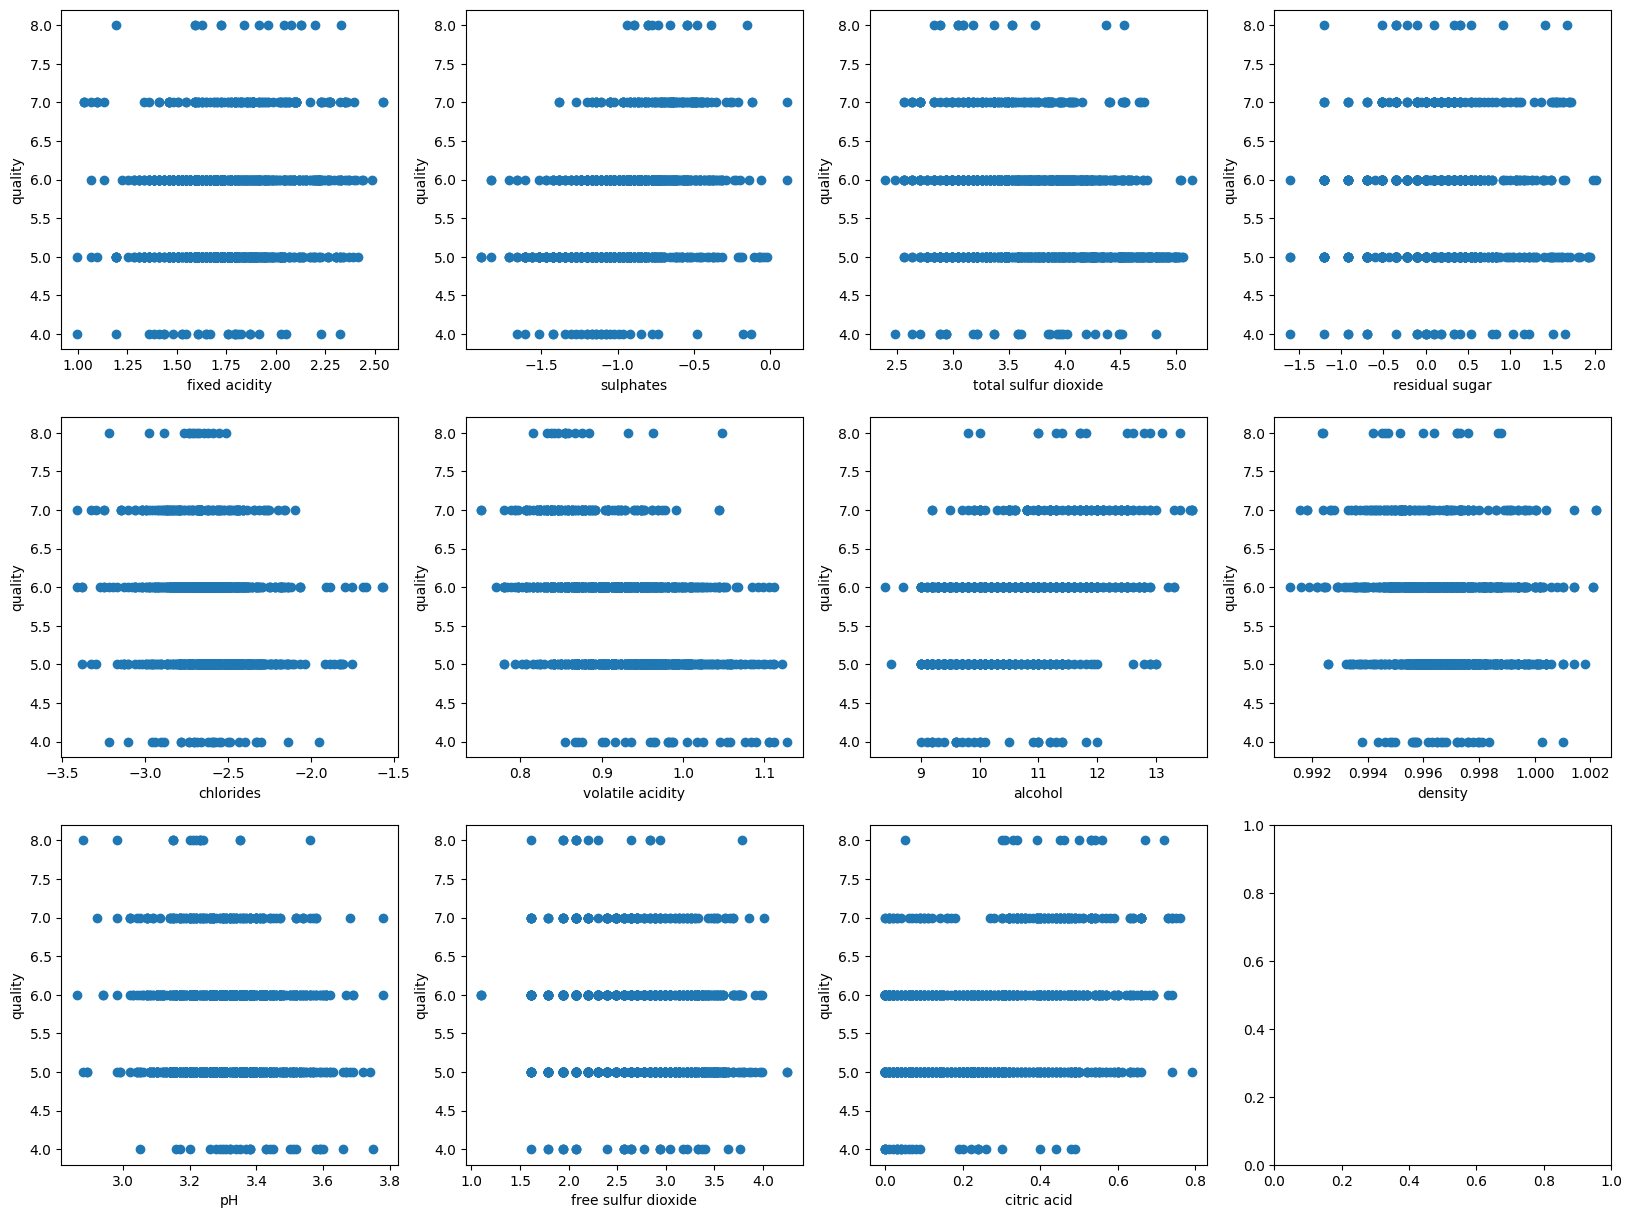

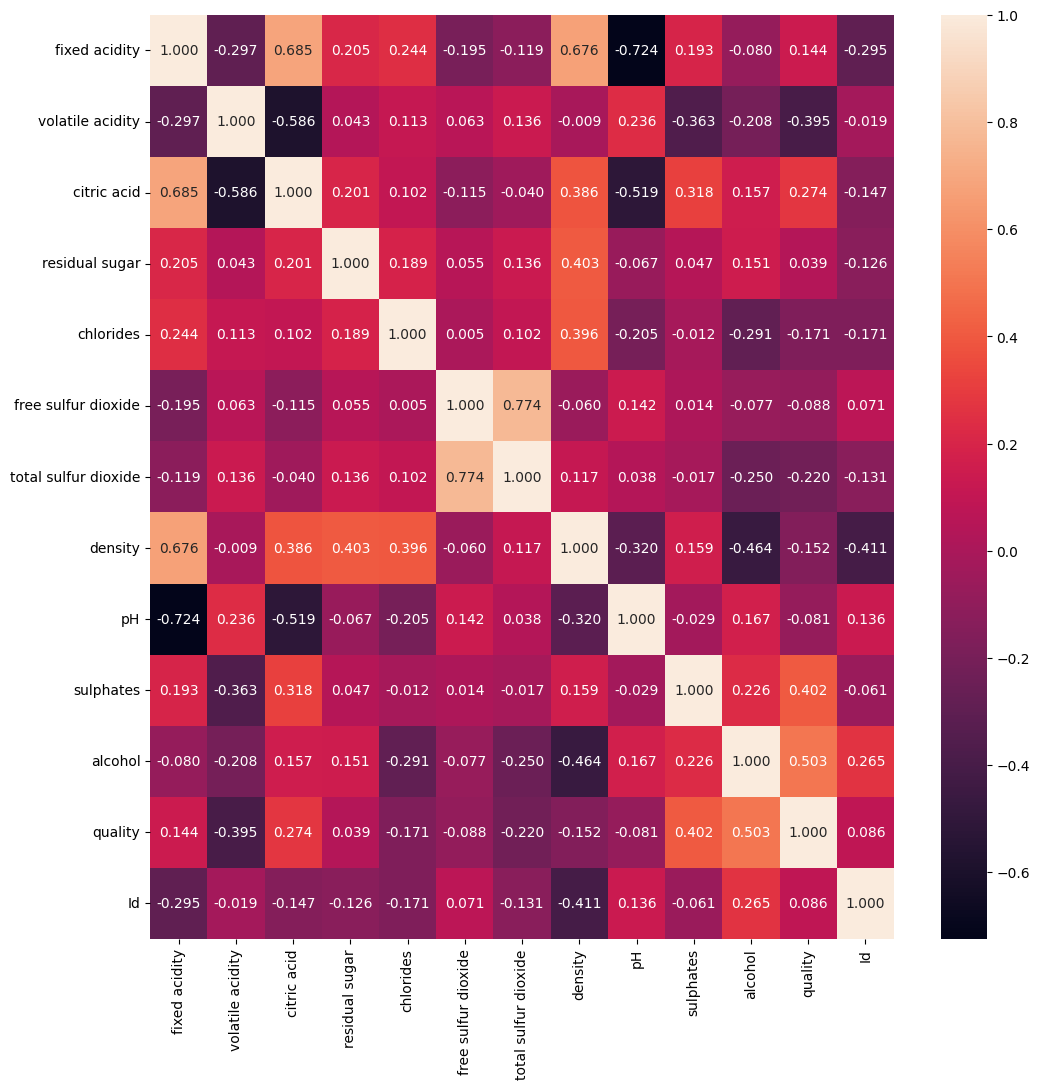

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
for n in range(11):
    i = n % 3
    j = n % 4
    ax[i, j].scatter(df.iloc[:, n], df['quality'])
    ax[i, j].set_xlabel(df.columns[n])
    ax[i, j].set_ylabel('quality')

import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 12))
correlation = df.corr()
sns.heatmap(correlation, annot=True, fmt='.3f')

Certaines caractéristiques sont particulièrement corrélées. Mais on ne détecte rien de très intéressant pour la qualité. Le coefficient R ne dépassant jamais 0.5, on va garder toutes les données et continuer.

Préparation des données :

In [9]:
import numpy as np
import matplotlib.pyplot as plt
# load the dataset

y = df['quality']
X= [df['fixed acidity'],  df['volatile acidity']  ,df['citric acid']  ,df['residual sugar'],  df['chlorides'],df['free sulfur dioxide']  ,df['total sulfur dioxide'],  df['density']    ,df['pH'],  df['sulphates']]
X=np.transpose(np.array(X))
y=np.asarray(y)
print(X.shape)
print(y.shape)
X_features = ['fixed acidity',  'volatile acidity'  ,'citric acid'  ,'residual sugar',  'chlorides','free sulfur dioxide'  ,'total sulfur dioxide',  'density'    ,'pH',  'sulphates']
nb_feature=len(X_features)

print("nombre d'observations X: ",len(X))
print("nombre d'observations y: ",len(y))




(1074, 10)
(1074,)
nombre d'observations X:  1074
nombre d'observations y:  1074


NOUVELLE MODIFICATION DU JEU DE DONNEES :

on a trop de vins de qualité égales à 5 ou 6... le modèle pourrait se concentrer sur des notes de 5 et 6 pour que la somme des erreures soit minimale. On va donc modifier le jeu de données pour avoir une répartition plus homogène.

Text(0.5, 1.0, 'quality après modification')

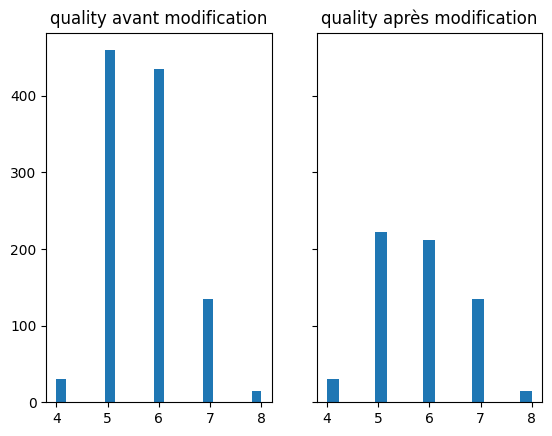

In [10]:
import random
supp=[]
for i in range(len(y)):
    if y[i]==5 or y[i]==6:
        rand=random.random()
        if(rand>0.5):
            supp.append(i)
y2=np.delete(y,supp)

X2=np.delete(X,supp,0)

#Plot des modifications
fig,ax=plt.subplots(1,2,sharey=True)
ax[0].hist(y, bins='auto',label="quality")
ax[0].set_title("quality avant modification")

ax[1].hist(y2, bins='auto',label="quality")
ax[1].set_title("quality après modification")

CREATION DES JEUX DE DONNEES:
Nous allons pour différents modèles faire de la cross validation. Nous avons pour cela besoin d'un jeu de données d'entrainement, d'un jeu de validation pour le choix des modèles/hyperparamètres et d'un jeu de test du modèle choisi.


In [11]:
#on créé les jeux de données
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X2, y2, test_size=0.4, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

print(X_train[:1])
print(y_train)
print("nombre d'observations X: ",len(X_train))
print("nombre d'observations y: ",len(y_train))

[[ 1.5260563   0.93609336  0.15        0.09531018 -2.6450754   3.04452244
   3.80666249  0.9961      3.41       -1.04982212]]
[5 6 6 6 7 4 5 5 8 5 5 5 6 7 7 6 5 7 5 6 6 4 6 6 6 6 4 6 7 8 5 7 5 7 5 5 7
 6 6 5 5 5 5 6 6 5 6 5 5 5 6 5 6 6 5 5 5 7 5 5 7 6 5 6 6 5 7 7 5 6 7 6 6 7
 6 5 5 7 5 8 6 6 7 7 5 5 6 6 7 6 6 6 6 7 6 4 6 4 6 6 7 7 7 7 5 6 7 5 5 6 6
 5 7 5 5 4 5 5 5 5 7 7 7 6 7 7 5 7 5 7 5 7 6 6 5 5 5 5 8 5 5 5 6 6 6 7 5 7
 6 6 6 5 4 5 5 5 6 6 6 6 5 5 8 5 8 7 5 6 5 6 6 7 5 6 5 5 6 6 7 5 6 5 4 6 6
 5 6 5 4 6 7 6 7 7 5 5 6 6 7 6 7 5 5 5 6 6 6 7 7 6 5 6 7 5 5 6 7 7 7 6 7 4
 5 7 5 5 6 6 4 6 5 6 6 7 8 7 6 6 6 6 5 6 6 5 5 7 4 6 5 5 6 6 7 5 4 6 7 6 4
 7 5 6 6 5 5 5 6 5 6 6 5 5 7 5 6 7 5 7 7 5 7 5 7 6 7 5 4 4 6 5 4 6 7 7 6 6
 6 5 6 5 6 6 7 6 7 7 5 7 5 6 5 6 5 6 6 5 5 8 5 7 5 5 7 5 7 6 5 5 5 6 5 6 4
 5 7 5 5 5 6 7 6 6 7 7 5 6 7 6 7 6 5 5 8 5 7 8 5 7 5 8 7 5 6 7 6 6 5]
nombre d'observations X:  367
nombre d'observations y:  367


PREMIERE METHODE : Regression Linéaire par moindre carrés avec régularisation:

Nous allons pour cette première méthode traiter la question comme une régression linéaire.
Avec quality = b1*fixe_acidity + b2* volatile_acidity+ ... + b10*sulphates
On va calculer ces coefficients avec cette méthodes pour plusieurs Lambda avec X_train, puis comparer les résultats en fonction de l'hyperparamètre Lambda sur X_cv et évaluer finalement notre modèle avec le meilleur Lambda sur X_test.

In [61]:
from numpy.linalg import inv

def moindre_carrees_regularise(X,y,Lambda):
    X=np.array(X)
    y=np.array(y)

    m=len(X[0])
    rterm=np.matmul(np.transpose(X), y)

    lterm=np.matmul(np.transpose(X),X) + Lambda * np.identity(m)

    beta=np.matmul(inv(lterm),rterm)

    return beta
                     

In [62]:
Lambdas=[0.1,1,10]
betas=[]
for loop in range(len(Lambdas)):
    betas.append(moindre_carrees_regularise(X_train,y_train,Lambdas[loop]))
    print(Lambdas[loop],"coefficients = ",betas[loop])

0.1 coefficients =  [-0.20436664 -0.82714516  1.01068463  0.10156906 -0.87774673  0.25610753
 -0.49820116  6.3134168   0.02402811  0.95631425]
1 coefficients =  [ 0.27930315 -0.17668466  1.04431502  0.07955597 -1.03747668  0.24764867
 -0.44324313  1.5075888   0.83043344  0.89241698]
10 coefficients =  [ 0.56118887  0.03624321  0.59384389  0.07143283 -1.00424933  0.16797184
 -0.28581496  0.39631324  0.86344168  0.73339056]


On a trouvé nos coefficients Beta, on va tester nos résultats:

In [63]:
def compute_cost(X, y, beta): 

    m = X.shape[0]
    
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], beta)            #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost
    

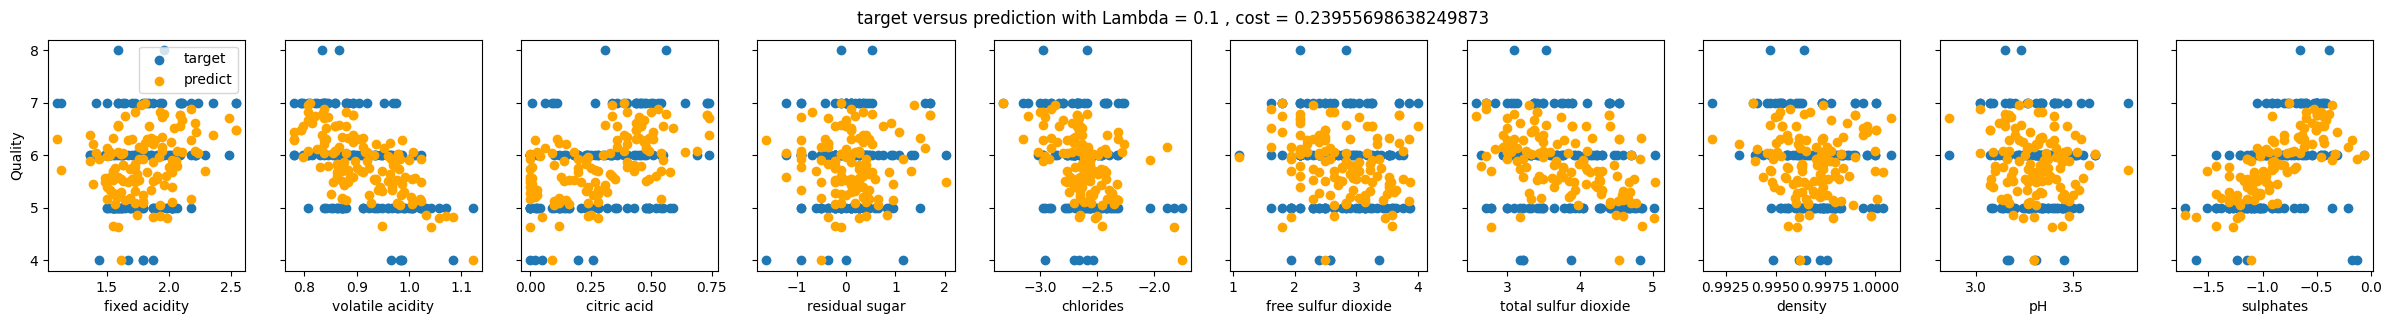

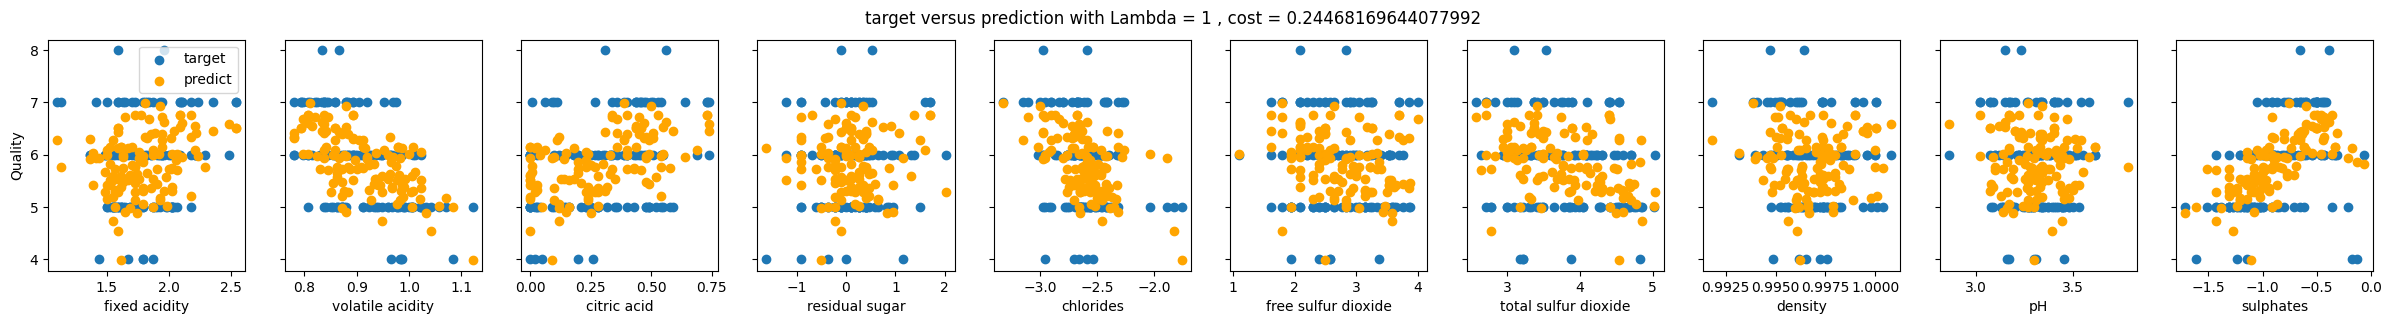

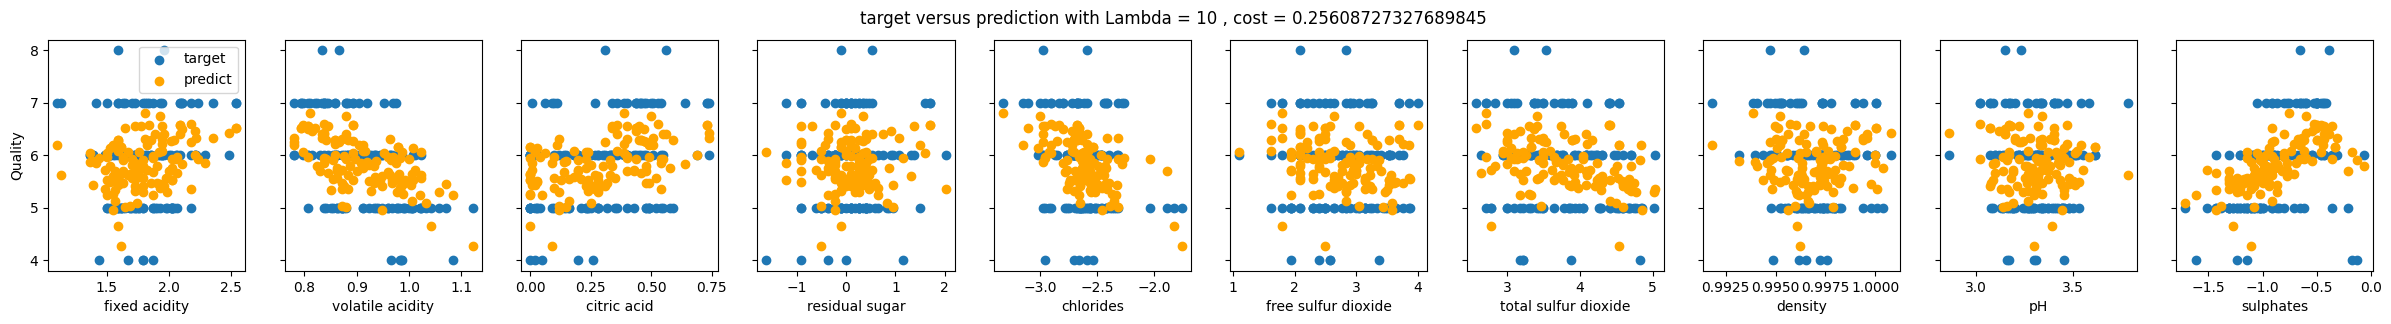

In [64]:
#predict target using normalized features
for loop in range(len(Lambdas)):
    m = X_cv.shape[0]
    yp = np.zeros(m)
    for i in range(m):
        yp[i] = np.dot(X_cv[i], betas[loop])

        # plot predictions and targets versus original features    
    fig,ax=plt.subplots(1,nb_feature,figsize=(30, 3),sharey=True)
    for i in range(len(ax)):
        ax[i].scatter([X_cv[:,i]],y_cv, label = 'target')
        ax[i].set_xlabel(X_features[i])
        ax[i].scatter([X_cv[:,i]],yp,color="orange", label = 'predict')
    ax[0].set_ylabel("Quality"); ax[0].legend()
    title="target versus prediction with Lambda = "+str(Lambdas[loop])+ " , cost = "+ str(compute_cost(X_cv,y_cv,betas[loop]))
    fig.suptitle(title)
    plt.show()

Plsu lambda D'après ces tests, on garde lambda = 0.1, évaluons le modèle sur le jeu de test.

In [1]:
print("cost final = ", str(compute_cost(X_test,y_test,betas[0])))

NameError: name 'compute_cost' is not defined

Le résultat ne parait pas très bon. La régression linéaire n'est pas adaptée car on doit trouver des valeurs discrètes.

DEUXIEME METHODE : la Descente de Gradient 
Pour trouver de nouveau les coefficients de la régression linéaire, nous allons utiliser la méthode de la descente de gradient.
Avec cette fois quality = w1*fixe_acidity + w2* volatile_acidity+ ... + w10*sulphates + b0

Cette méthode actualiste de manière itérative les coefficients W et b0 pour minimiser le cout (= l'erreur moyenne de prédiction).

Elle est moins rapide que la regression précédente mais a l'avantage de pouvoir être utilisée pour n'importe quelle quality = g(W,b) (pas seulement un problème linéaire)
Testons cette méthode d'abord pour une regression linéaire.


Codes

In [66]:
import copy
import math


def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                    
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                      
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = compute_gradient(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            
           print("Iteration", i,": Cost ", J_history[-1])
        
    return w, b, np.squeeze(J_history) #return final w,b and J history for graphing

Application:

(367, 10)
(367,)
w_init shape: (10,), b_init type: <class 'int'>
test cout :  17.450953678474114
Iteration 0 : Cost  12.429153590139448
Iteration 200 : Cost  0.333611336214134
Iteration 400 : Cost  0.3149164485057921
Iteration 600 : Cost  0.31067371922528314
Iteration 800 : Cost  0.30905572605133813
Iteration 1000 : Cost  0.3080868131210912
Iteration 1200 : Cost  0.30734911231063483
Iteration 1400 : Cost  0.3067324741172703
Iteration 1600 : Cost  0.3061976130256535
Iteration 1800 : Cost  0.305724917820679
 Coefficients b,w trouvés: 0.5692034468473857,[ 0.39753996 -0.09166909  0.90380486  0.08295618 -1.08330392  0.2528869
 -0.45291389  0.53387846  0.85863682  0.93507155] 


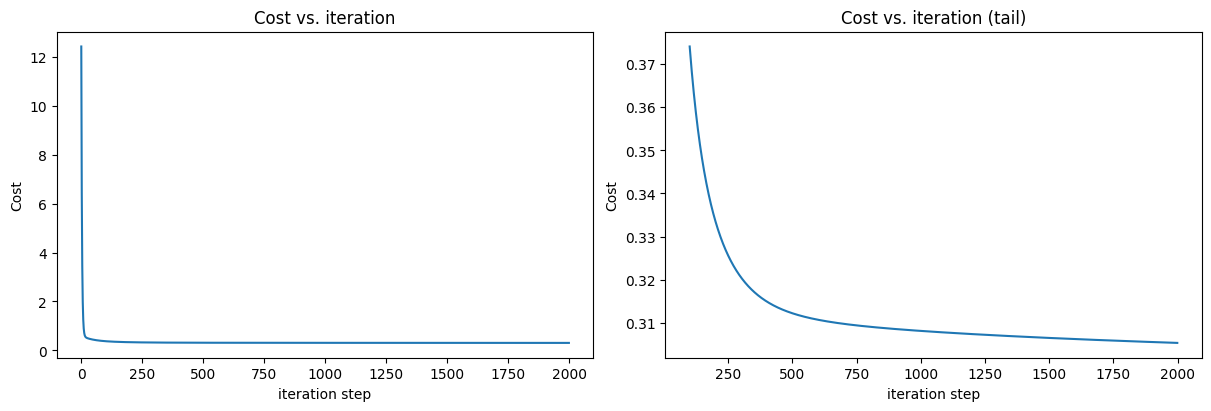

In [69]:
#Paramètres:
b_init = 0
w_init = np.array([ 0,0,0,0,0,0,0,0,0,0])
initial_w = np.zeros_like(w_init)
initial_b = 0.
print(X_train.shape)
print(y_train.shape)
#test calcul d'un coût
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")
print("test cout : ",compute_cost(X_train, y_train, initial_w, initial_b))

# gradient descent settings
iterations = 2000
alpha =  4e-2

# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,alpha, iterations)
print(f" Coefficients b,w trouvés: {b_final},{w_final} ")
m,_ = X_train.shape

# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()



La descente de gradient nous donne les coefficients de la régression linéaire qui minimise l'erreur.
On voit l'évolution de l'erreur moyenne en fonction de l'itération.

INFLUENCE DE L'HYPERPARAMETRE ALPHA

Alpha est l'hyperparamètre de la descente de gradient qui met à jour les coefficients de la regression à chaque itération. Plus alpha sera grand, plus l'ajustement à chaque itération sera important.

Iteration 0 : Cost  8133.0747414469515


/tmp/ipykernel_60614/1263849773.py:22: RuntimeWarning: overflow encountered in double_scalars
  cost = cost + (f_wb_i - y[i])**2       #scalar


Iteration 200 : Cost  inf


/tmp/ipykernel_60614/1263849773.py:46: RuntimeWarning: overflow encountered in double_scalars
  dj_dw[j] = dj_dw[j] + err * X[i, j]
/tmp/ipykernel_60614/1263849773.py:46: RuntimeWarning: invalid value encountered in double_scalars
  dj_dw[j] = dj_dw[j] + err * X[i, j]
/tmp/ipykernel_60614/1263849773.py:84: RuntimeWarning: invalid value encountered in subtract
  w = w - alpha * dj_dw               ##None


Iteration 400 : Cost  nan
Iteration 600 : Cost  nan
Iteration 800 : Cost  nan
Iteration 1000 : Cost  nan
Iteration 1200 : Cost  nan
Iteration 1400 : Cost  nan
Iteration 1600 : Cost  nan
Iteration 1800 : Cost  nan
Iteration 0 : Cost  10.600535838942212
Iteration 200 : Cost  0.5004762342415245
Iteration 400 : Cost  0.4374947177159152
Iteration 600 : Cost  0.39927684045640205
Iteration 800 : Cost  0.37506161912093766
Iteration 1000 : Cost  0.3590059340356594
Iteration 1200 : Cost  0.34788143744022226
Iteration 1400 : Cost  0.33986301860247026
Iteration 1600 : Cost  0.3338881980055245
Iteration 1800 : Cost  0.3293161009151582


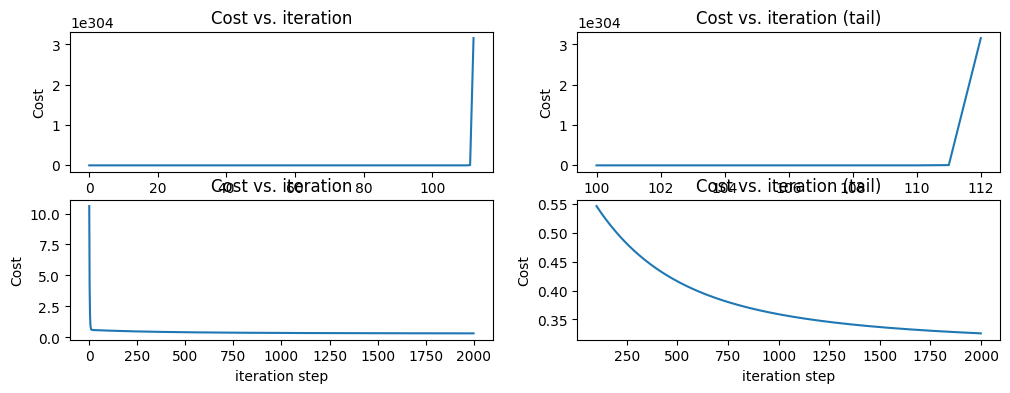

In [70]:
alpha1 = 5.0e-1
alpha2 = 5.0e-3
fig, [[ax1,ax2],[ax3,ax4]]= plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
w_final1, b_final1, J_hist1 = gradient_descent(X_train, y_train, initial_w, initial_b,alpha1, iterations)
w_final2, b_final2, J_hist2 = gradient_descent(X_train, y_train, initial_w, initial_b,alpha2, iterations)



ax1.plot(J_hist1)
ax2.plot(100 + np.arange(len(J_hist1[100:])), J_hist1[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 

ax3.plot(J_hist2)
ax4.plot(100 + np.arange(len(J_hist2[100:])), J_hist2[100:])
ax3.set_title("Cost vs. iteration");  ax4.set_title("Cost vs. iteration (tail)")
ax3.set_ylabel('Cost')             ;  ax4.set_ylabel('Cost') 
ax3.set_xlabel('iteration step')   ;  ax4.set_xlabel('iteration step') 
plt.show()

Le premier alpha est trop grand, on saute l'optimum. Le second est trop petit, on ne l'atteint qu'après un trop grand nombre d'itérations...

TEST DU RESULTAT: Après avoir trouver nos coefficients permettant de minimiser l'erreur, on peut visualiser nos prédictions.

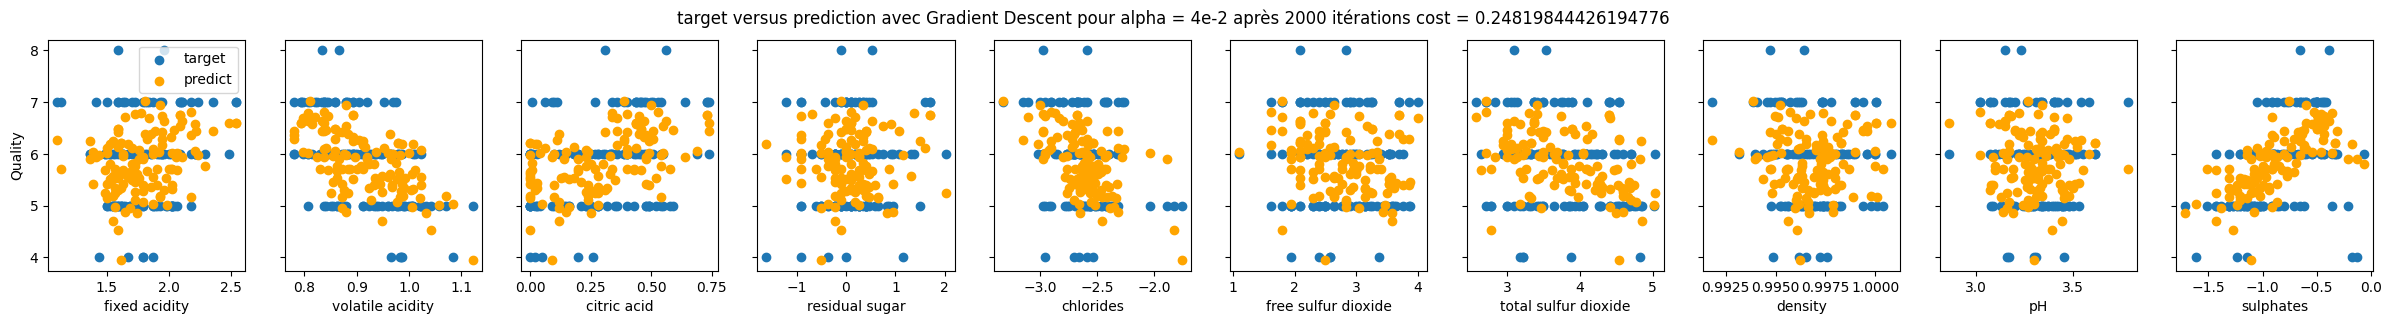

In [72]:
#predict target using normalized features
m = X_cv.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_cv[i], w_final) + b_final

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,nb_feature,figsize=(30, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter([X_cv[:,i]],y_cv, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter([X_cv[:,i]],yp,color="orange", label = 'predict')
ax[0].set_ylabel("Quality"); ax[0].legend()
title="target versus prediction avec Gradient Descent pour alpha = 4e-2 après 2000 itérations cost = "+ str(compute_cost(X_cv, y_cv, w_final, b_final))
fig.suptitle(title)
plt.show()

Le coût est similaire, un petit peu plus élevé. Nous allons maintenant utiliser la méthode de la descente de gradient pour un nouveau type de fonctions quality = g(W,b)
avec g qui va nous donner la probabilité d'appertenance d'un x à une qualité y. C'est l'algorithme Softmax.